In [ ]:
# Section 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gdown
import zipfile
import gc
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define the class ID to name dictionary
class_id_to_name = {
    0: 'speed limit 20 (prohibitory)', 1: 'speed limit 30 (prohibitory)', 2: 'speed limit 50 (prohibitory)',
    3: 'speed limit 60 (prohibitory)', 4: 'speed limit 70 (prohibitory)', 5: 'speed limit 80 (prohibitory)',
    6: 'restriction ends 80 (other)', 7: 'speed limit 100 (prohibitory)', 8: 'speed limit 120 (prohibitory)',
    9: 'no overtaking (prohibitory)', 10: 'no overtaking (trucks) (prohibitory)', 11: 'priority at next intersection (danger)',
    12: 'priority road (other)', 13: 'give way (other)', 14: 'stop (other)', 15: 'no traffic both ways (prohibitory)',
    16: 'no trucks (prohibitory)', 17: 'no entry (other)', 18: 'danger (danger)', 19: 'bend left (danger)',
    20: 'bend right (danger)', 21: 'bend (danger)', 22: 'uneven road (danger)', 23: 'slippery road (danger)',
    24: 'road narrows (danger)', 25: 'construction (danger)', 26: 'traffic signal (danger)', 27: 'pedestrian crossing (danger)',
    28: 'school crossing (danger)', 29: 'cycles crossing (danger)', 30: 'snow (danger)', 31: 'animals (danger)',
    32: 'restriction ends (other)', 33: 'go right (mandatory)', 34: 'go left (mandatory)', 35: 'go straight (mandatory)',
    36: 'go right or straight (mandatory)', 37: 'go left or straight (mandatory)', 38: 'keep right (mandatory)',
    39: 'keep left (mandatory)', 40: 'roundabout (mandatory)', 41: 'restriction ends (overtaking) (other)',
    42: 'restriction ends (overtaking (trucks)) (other)'
}

# Download the entire Classification dataset as a zip file
url = "https://drive.google.com/file/d/1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE/view?usp=sharing"  # Direct link to the Google Drive file
output = "/content/classification.zip"

# Use gdown to download the file
gdown.download(url=url, output=output, fuzzy=True)

# Extract the downloaded zip file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Step 2: Load and Understand Annotations
def load_annotations(csv_path):
    return pd.read_csv(csv_path, sep=';')

train_annotations = load_annotations('/content/classification/data/train/Final_Training/GT_Train.csv')
test_annotations = load_annotations('/content/classification/data/test/GT-final_test.csv')

# Function to preprocess images
def preprocess_image(image_path, bbox):
    if not os.path.exists(image_path):
        print(f"Image path does not exist: {image_path}")
        return None

    image = cv2.imread(image_path)  # or PIL.Image.open(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]
    resized_image = cv2.resize(cropped_image, (75, 75))  # Resize to 75x75
    normalized_image = resized_image / 255.0  # Normalize pixel values
    return normalized_image

# Function to load images and labels for training data
def load_train_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        class_id = f"{row['ClassId']:05d}"
        filename = row['Filename']
        # Construct the correct image path
        image_path = os.path.join(base_path, class_id, filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        label = row['ClassId']
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to load images and labels for test data
def load_test_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        filename = row['Filename']
        image_path = os.path.join(base_path, filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

# Ensure the paths to annotations are correct
print("Train Annotations Head:\n", train_annotations.head())
print("Test Annotations Head:\n", test_annotations.head())

# Load images and labels
train_images, train_labels = load_train_images_and_labels(train_annotations, '/content/classification/data/train/Final_Training/Images')
test_images, test_labels = load_test_images_and_labels(test_annotations, '/content/classification/data/test/Final_Test/Images')

# Prepare data for training
num_classes = train_annotations['ClassId'].nunique()
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


Downloading...
From (original): https://drive.google.com/uc?id=1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE
From (redirected): https://drive.google.com/uc?id=1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE&confirm=t&uuid=f0847cf1-a1c7-45d4-8a97-c9896b07cbd7
To: /content/classification.zip
100%|██████████| 369M/369M [00:02<00:00, 133MB/s]


Train Annotations Head:
           Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000_00000.ppm     26      26       5       5      20      21       33
1  00000_00001.ppm     27      28       5       6      22      23       33
2  00000_00002.ppm     27      27       5       5      22      21       33
3  00000_00003.ppm     28      27       6       5      23      22       33
4  00000_00004.ppm     27      29       5       6      22      24       33
Test Annotations Head:
     Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000.ppm     53      54       6       5      48      49       16
1  00001.ppm     42      45       5       5      36      40        1
2  00002.ppm     48      52       6       6      43      47       38
3  00003.ppm     27      29       5       5      22      24       33
4  00004.ppm     60      57       5       5      55      52       11


In [ ]:

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=99)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)


In [ ]:

# Fine Tuning InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Add new top layers for our specific problem
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the new model
inception_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers except the last 2 convolutional blocks and dense layers
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Compile the model
inception_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply data augmentation to the training dataset
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

# Define early stopping and model checkpoint callbacks
inception_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_finetuned_inception_model.h5', save_best_only=True)
]


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:

# Train the model
inception_history = inception_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=inception_callbacks
)


Epoch 1/100
978/981 [============================>.] - ETA: 0s - loss: 1.9178 - accuracy: 0.4976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 35s 21ms/step - loss: 1.9162 - accuracy: 0.4979 - val_loss: 0.7553 - val_accuracy: 0.7554
Epoch 2/100
981/981 [==============================] - 17s 17ms/step - loss: 0.9872 - accuracy: 0.7017 - val_loss: 0.5294 - val_accuracy: 0.8287
Epoch 3/100
981/981 [==============================] - 18s 17ms/step - loss: 0.6960 - accuracy: 0.7781 - val_loss: 0.4354 - val_accuracy: 0.8602
Epoch 4/100
981/981 [==============================] - 19s 18ms/step - loss: 0.5303 - accuracy: 0.8276 - val_loss: 0.3592 - val_accuracy: 0.8824
Epoch 5/100
981/981 [==============================] - 17s 17ms/step - loss: 0.4135 - accuracy: 0.8642 - val_loss: 0.3269 - val_accuracy: 0.8944
Epoch 6/100
981/981 [==============================] - 18s 17ms/step - loss: 0.3438 - accuracy: 0.8845 - val_loss: 0.2964 - val_accuracy: 0.9047
Epoch 7/100
981/981 [==============================] - 17s 16ms/step - loss: 0.2837 - accuracy: 0.9051 - val_loss: 0.3100 - val_accuracy: 0.90

In [ ]:

# Predict on the test set
y_test_pred_inception = inception_model.predict(test_dataset)
y_test_pred_classes_inception = np.argmax(y_test_pred_inception, axis=1)
y_test_true = np.argmax(test_labels, axis=1)

# Calculate accuracy for InceptionNet model
test_accuracy_inception = accuracy_score(y_test_true, y_test_pred_classes_inception)
print(f'Test Accuracy (InceptionNet): {test_accuracy_inception:.4f}')

# Generate classification report for InceptionNet model
class_report_inception = classification_report(y_test_true, y_test_pred_classes_inception, target_names=class_id_to_name.values())
print('Classification Report (InceptionNet):')
print(class_report_inception)


395/395 [==============================] - 6s 10ms/step
Test Accuracy (InceptionNet): 0.7551
Classification Report (InceptionNet):
                                                precision    recall  f1-score   support

                  speed limit 20 (prohibitory)       0.61      0.38      0.47        60
                  speed limit 30 (prohibitory)       0.65      0.73      0.69       720
                  speed limit 50 (prohibitory)       0.63      0.71      0.66       750
                  speed limit 60 (prohibitory)       0.55      0.52      0.53       450
                  speed limit 70 (prohibitory)       0.78      0.70      0.74       660
                  speed limit 80 (prohibitory)       0.60      0.68      0.64       630
                   restriction ends 80 (other)       0.91      0.71      0.80       150
                 speed limit 100 (prohibitory)       0.84      0.80      0.82       450
                 speed limit 120 (prohibitory)       0.69      0.61      0.6

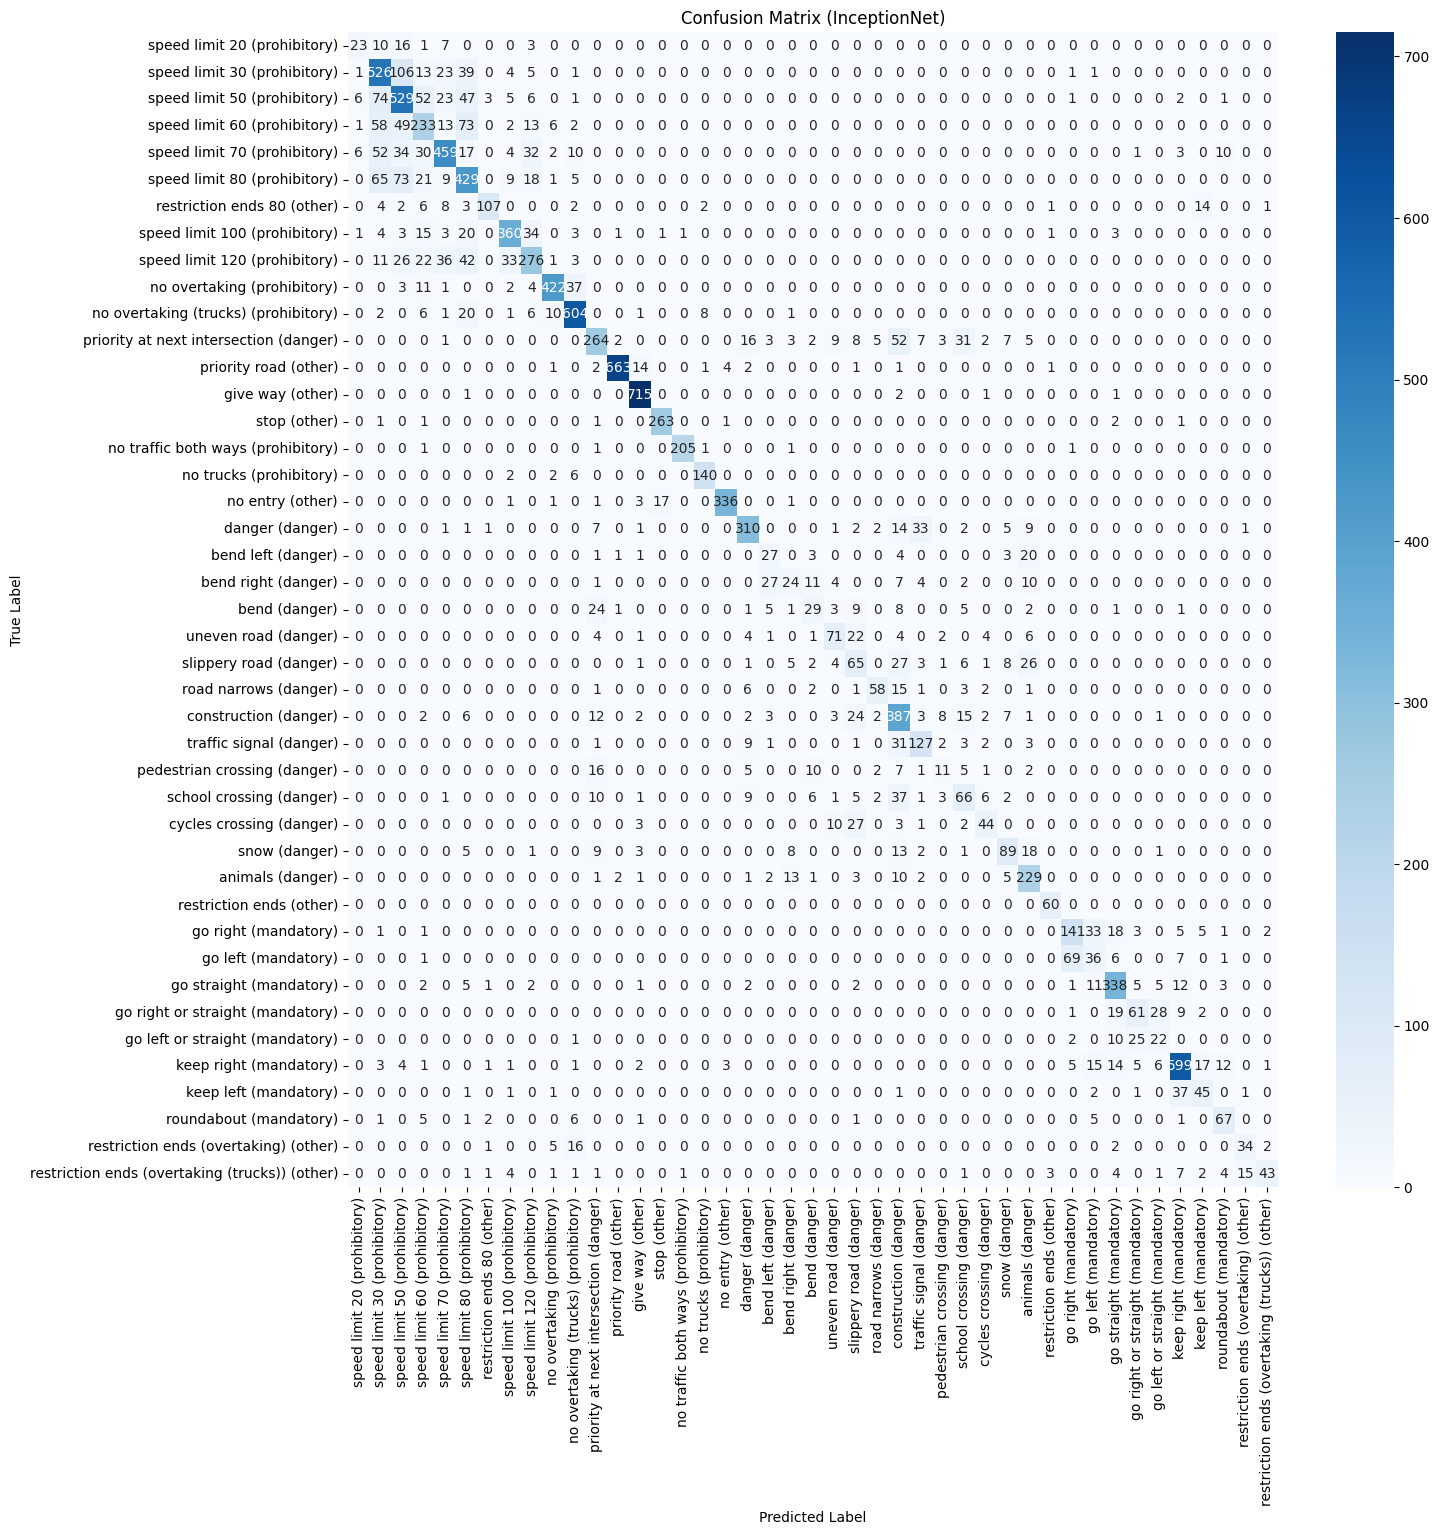

In [ ]:

# Generate confusion matrix for InceptionNet model
conf_matrix_inception = confusion_matrix(y_test_true, y_test_pred_classes_inception)

# Plot confusion matrix for InceptionNet model
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_inception, annot=True, fmt='d', cmap='Blues', xticklabels=class_id_to_name.values(), yticklabels=class_id_to_name.values())
plt.title('Confusion Matrix (InceptionNet)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


                                             Class  False Positive  \
0                     speed limit 20 (prohibitory)              15   
1                     speed limit 30 (prohibitory)             286   
2                     speed limit 50 (prohibitory)             316   
3                     speed limit 60 (prohibitory)             191   
4                     speed limit 70 (prohibitory)             127   
5                     speed limit 80 (prohibitory)             282   
6                      restriction ends 80 (other)              10   
7                    speed limit 100 (prohibitory)              69   
8                    speed limit 120 (prohibitory)             124   
9                      no overtaking (prohibitory)              31   
10            no overtaking (trucks) (prohibitory)              95   
11          priority at next intersection (danger)              93   
12                           priority road (other)               7   
13                  

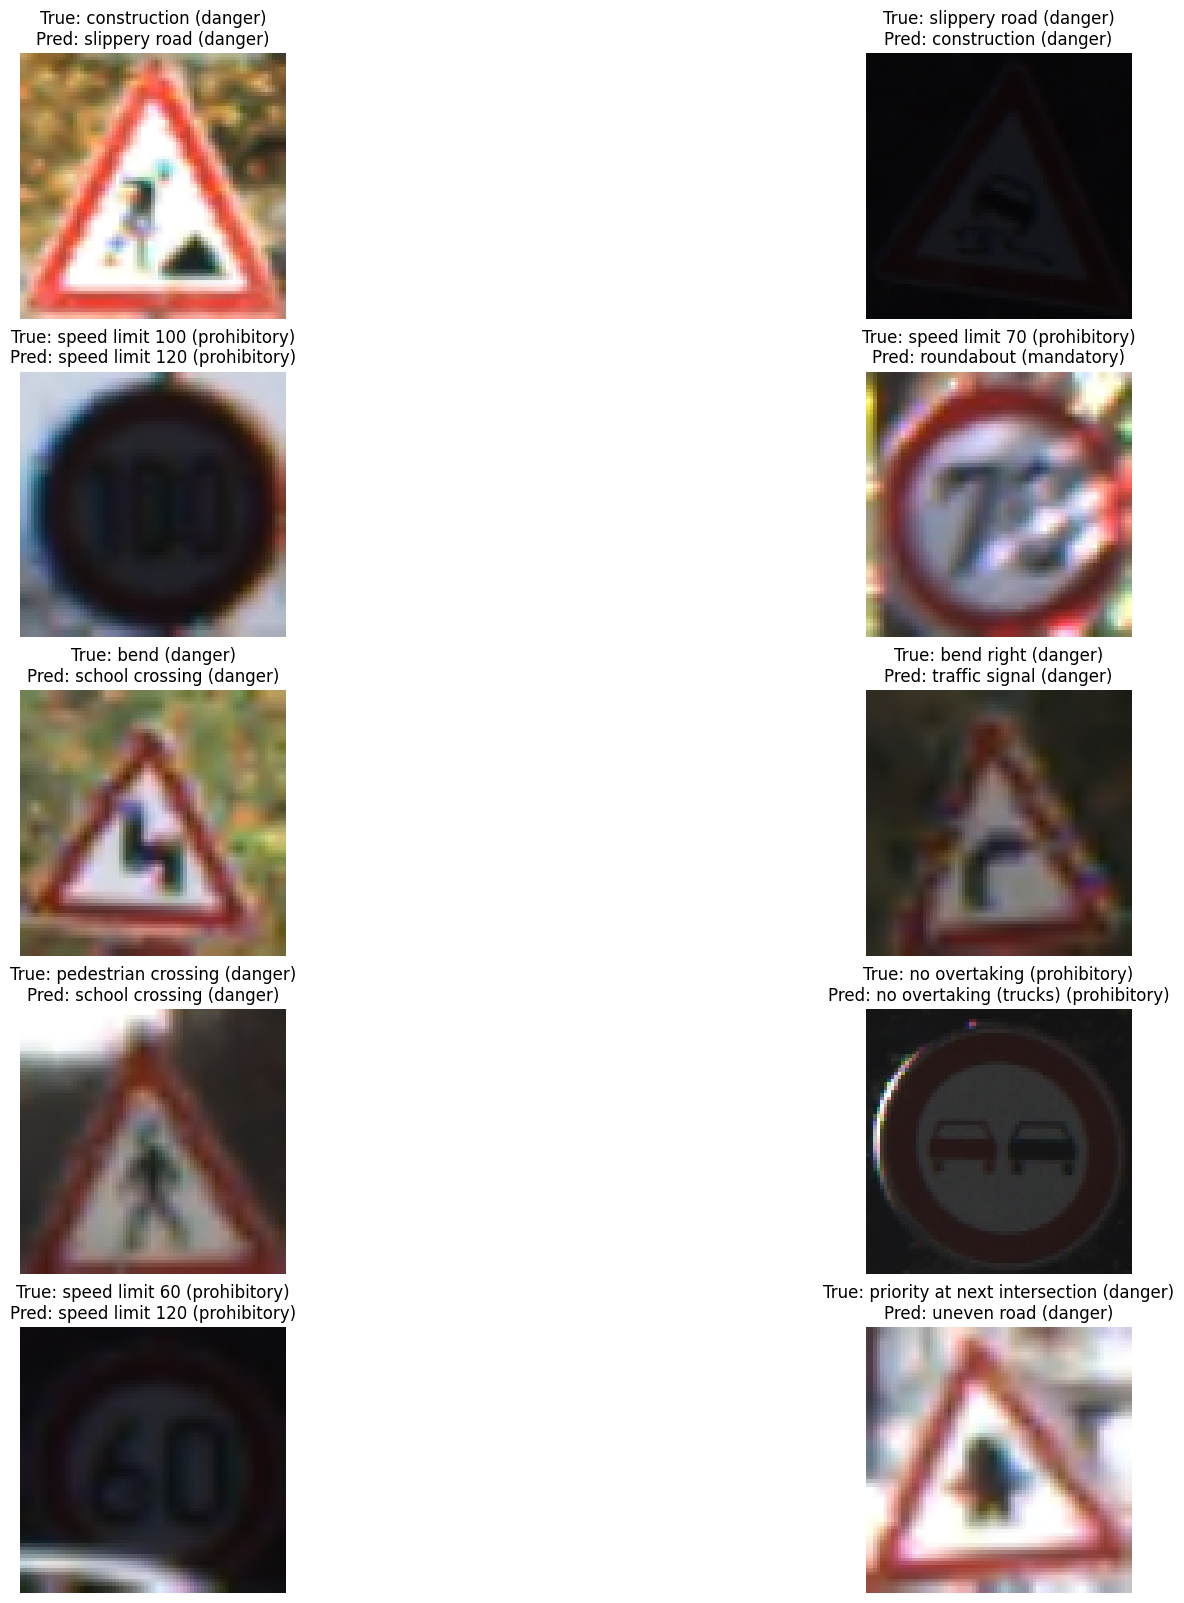

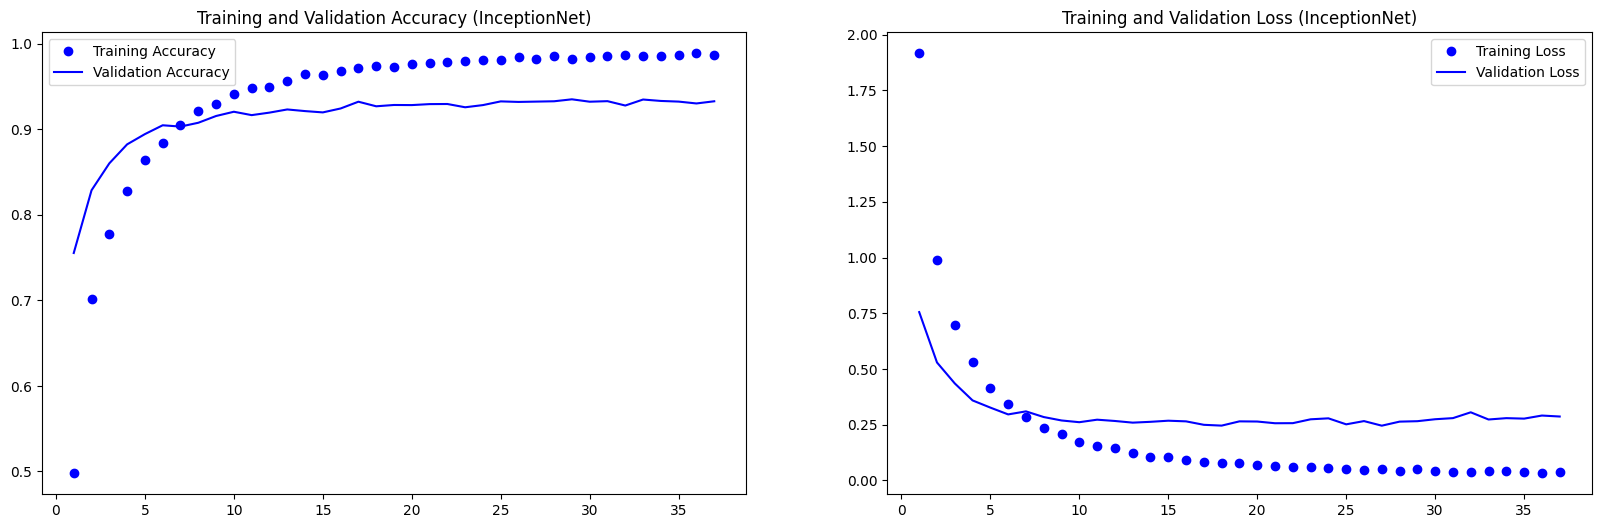

In [ ]:

# Calculate TP, FP, FN, TN for each class
def calculate_metrics_per_class(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)
    return FP, FN, TP, TN

FP_inception, FN_inception, TP_inception, TN_inception = calculate_metrics_per_class(conf_matrix_inception)

metrics_df_inception = pd.DataFrame({
    'Class': list(class_id_to_name.values()) + ['Overall'],
    'False Positive': list(FP_inception) + [FP_inception.sum()],
    'False Negative': list(FN_inception) + [FN_inception.sum()],
    'True Positive': list(TP_inception) + [TP_inception.sum()],
    'True Negative': list(TN_inception) + [TN_inception.sum()]
})
print(metrics_df_inception)

# Function to show misclassified images
def show_misclassified_images(images, true_labels, pred_labels, class_names, num_images=10):
    misclassified_indices = np.where(true_labels != pred_labels)[0]
    plt.figure(figsize=(20, 20))
    for i, idx in enumerate(misclassified_indices[:num_images]):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[idx])
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()

# Prepare data for visualization
# As the dataset is batched, we need to convert it back to arrays for visualization
test_images_list = list(test_dataset.as_numpy_iterator())
test_images = np.concatenate([batch[0] for batch in test_images_list])
test_labels = np.concatenate([batch[1] for batch in test_images_list])

# Class names
class_names = [class_id_to_name[i] for i in range(num_classes)]

# Show misclassified images
show_misclassified_images(test_images, y_test_true, y_test_pred_classes_inception, class_names)

# Function to plot the training and validation metrics for InceptionNet model
def plot_inception_metrics(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy (InceptionNet)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "b", label="Validation Loss")
    plt.title("Training and Validation Loss (InceptionNet)")
    plt.legend()

    plt.show()

# Plot the metrics for InceptionNet model
plot_inception_metrics(inception_history)


In [ ]:
def calculate_total_metrics(conf_matrix):
    """
    Calculate the total TP, FP, FN, TN for the entire confusion matrix.

    Parameters:
    - conf_matrix: Confusion matrix.

    Returns:
    - metrics: Dictionary with total TP, FP, FN, TN.
    """
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)

    metrics = {
        'Total True Positives (TP)': TP.sum(),
        'Total False Positives (FP)': FP.sum(),
        'Total False Negatives (FN)': FN.sum(),
        'Total True Negatives (TN)': TN.sum()
    }

    return metrics

# Example usage
conf_matrix_inception = confusion_matrix(y_test_true, y_test_pred_classes_inception)
total_metrics = calculate_total_metrics(conf_matrix_inception)
print(total_metrics)


{'Total True Positives (TP)': 9537, 'Total False Positives (FP)': 3093, 'Total False Negatives (FN)': 3093, 'Total True Negatives (TN)': 527367}


In [ ]:
import time

def measure_network_speed(model, dataset, num_batches=10):
    """
    Measure the speed of the neural network.

    Parameters:
    - model: Trained Keras model.
    - dataset: TensorFlow dataset to measure predictions on.
    - num_batches: Number of batches to measure for averaging.

    Returns:
    - avg_time_per_batch: Average time taken per batch in seconds.
    """
    total_time = 0.0
    batch_count = 0

    for batch_data, _ in dataset.take(num_batches):
        start_time = time.time()
        _ = model.predict(batch_data)
        end_time = time.time()

        total_time += end_time - start_time
        batch_count += 1

    avg_time_per_batch = total_time / batch_count
    return avg_time_per_batch

# Example usage
avg_time_per_batch = measure_network_speed(inception_model, test_dataset, num_batches=10)
print(f'Average time per batch: {avg_time_per_batch:.4f} seconds')


1/1 [==============================] - 0s 26ms/step
Average time per batch: 0.2020 seconds
